classificar em 2 a 8 hz

In [1]:
import pyedflib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.fftpack import rfft, irfft, fftfreq
import scipy as sp
from scipy import signal

import os
import itertools

from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

%matplotlib inline

In [2]:
HOME = "/Users/jonat/OneDrive/Documents/Protocolo_PKS/Protocolo_PKS/dados_edf/DB_REPO/edf/"
def dadosPK(tipo):
    dir_ct = HOME+tipo+"/"
    return os.listdir(HOME+tipo+"/")

In [3]:
def carregarDataFrame(tipo, caminho):
    caminho = HOME+tipo+"/"+caminho
    
    edf = pyedflib.EdfReader(caminho)
    n = edf.signals_in_file
    sigbufs = np.zeros((n, edf.getNSamples()[0]))
    for i in np.arange(n):
         sigbufs[i, :] = edf.readSignal(i)
    edf._close()
    del edf
    data = sigbufs.T
    #scaler = MinMaxScaler()
    #scaler.fit(dados)
    #data = scaler.transform(dados)
    
    return pd.DataFrame(data=data, columns=['ch1', 'ch2', 'ch3', 'ch4'])

In [4]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Matriz de confusão, sem normalização', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Esperado')
    plt.xlabel('Obtido')

In [5]:
def bandpass_filter(emg, low_pass=10., sfreq=2000., high_band=4., low_band=8.):
    # create bandpass filter for EMG
    high = high_band/(sfreq/2)
    low = low_band/(sfreq/2)
    b, a = sp.signal.butter(4, [high,low], btype='bandpass')

    # process EMG signal: filter EMG
    return sp.signal.filtfilt(b, a, emg)

In [6]:
def lowpass_filter(emg, low_pass=10., sfreq=2000., high_band=20., low_band=450.):
    low_pass = low_pass/sfreq
    b2, a2 = sp.signal.butter(4, low_pass, btype='lowpass')
    return sp.signal.filtfilt(b2, a2, emg)

In [7]:
def fft(df, canal):
    amostras = int(df[canal][2000:11000].shape[0]*500/2000)
    sinal = np.abs(np.fft.fft(df[canal][2000:11000]))[:amostras]
    freq = np.linspace(0,500,amostras)
    return (sinal,freq)

def frequeciaBD(df, canal):
    sinalFFT = [bandpass_filter(fft(data, canal)[0]) for data in df]
    return sinalFFT

def frequecia(df, canal):
    sinalFFT = [fft(data, canal)[0] for data in df]
    return sinalFFT

def plotarFFT(a, b, titulo):
    plt.title(titulo)
    plt.plot(b,a)
    plt.xlim([0,500])
    plt.ylim([0,5000])
    plt.show

In [8]:
nomes_parkinson = dadosPK('parkinson')
nomes_controle = dadosPK('controle')
df_ct = [ carregarDataFrame('controle', nome) for nome in nomes_controle]
df_pk = [ carregarDataFrame('parkinson', nome) for nome in nomes_parkinson]

# Filtrando os dados com a fft

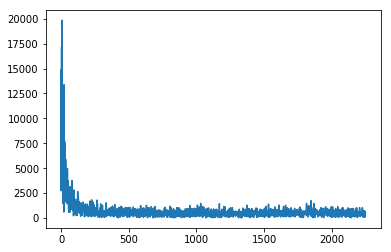

In [9]:
sinalCT = frequecia(df_ct, 'ch1')
sinalPK = frequecia(df_pk, 'ch1')

sinalCTBD = frequeciaBD(df_ct, 'ch1')
sinalPKBD = frequeciaBD(df_pk, 'ch1')

rotulosCT = [0 for _ in sinalCT]
rotulosPK = [1 for _ in sinalPK]
plt.plot(sinalCT[0])

## Separando os dados (Treino, teste e validação)

In [10]:
trainData = sinalCT + sinalPK
trainDataBD = sinalCT + sinalPK
rotulos = rotulosCT + rotulosPK

In [11]:
# Croos validation
X_train, X_test, y_train, y_test = train_test_split(trainData, rotulos, test_size=0.3, random_state=32)
X_validate, X_test, y_validade, y_test = train_test_split(X_test, y_test, test_size=0.5) #34,47,77, 9,

# Croos validation
X_train, X_test, y_train, y_teste = train_test_split(trainData, rotulos, test_size=0.3)

## Selhecionando melhores parametros

In [12]:
param_grid = [
    {'C': [1], 'gamma': [0.1, 0.2], 'kernel':['poly'], 'degree':[3,4]}
]

In [13]:
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)

## Treinando

In [14]:
%%time
grid.fit(X_train, y_train)
print('grid')
print(grid.best_params_)
print(grid.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] C=1, degree=3, gamma=0.1, kernel=poly ...........................
[CV]  C=1, degree=3, gamma=0.1, kernel=poly, score=0.75, total=   0.0s
[CV] C=1, degree=3, gamma=0.1, kernel=poly ...........................
[CV]  C=1, degree=3, gamma=0.1, kernel=poly, score=0.7368421052631579, total=   0.0s
[CV] C=1, degree=3, gamma=0.1, kernel=poly ...........................
[CV]  C=1, degree=3, gamma=0.1, kernel=poly, score=0.6842105263157895, total=   0.0s
[CV] C=1, degree=3, gamma=0.2, kernel=poly ...........................
[CV]  C=1, degree=3, gamma=0.2, kernel=poly, score=0.75, total=   0.0s
[CV] C=1, degree=3, gamma=0.2, kernel=poly ...........................
[CV]  C=1, degree=3, gamma=0.2, kernel=poly, score=0.7368421052631579, total=   0.0s
[CV] C=1, degree=3, gamma=0.2, kernel=poly ...........................
[CV]  C=1, degree=3, gamma=0.2, kernel=poly, score=0.6842105263157895, total=   0.0s
[CV] C=1, degree=4, gamma=0.1, k

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished


In [15]:
y_pred = grid.predict(X_test)

## Validando

In [16]:
nomes = ['controle','parkinson']

In [17]:
print(classification_report(y_pred, y_test,target_names=nomes))

             precision    recall  f1-score   support

   controle       0.86      1.00      0.92         6
  parkinson       1.00      0.86      0.92         7

avg / total       0.93      0.92      0.92        13



<Figure size 432x288 with 0 Axes>

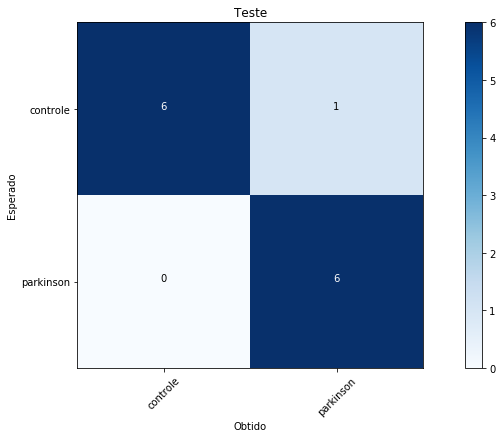

In [18]:
# Matriz de confusão
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# Sem normalização
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=False, classes=nomes, title="Teste")

In [19]:
y_predV = grid.predict(X_validate)

In [20]:
print(classification_report(y_predV, y_validade,target_names=nomes))

             precision    recall  f1-score   support

   controle       1.00      0.78      0.88         9
  parkinson       0.67      1.00      0.80         4

avg / total       0.90      0.85      0.85        13



<Figure size 432x288 with 0 Axes>

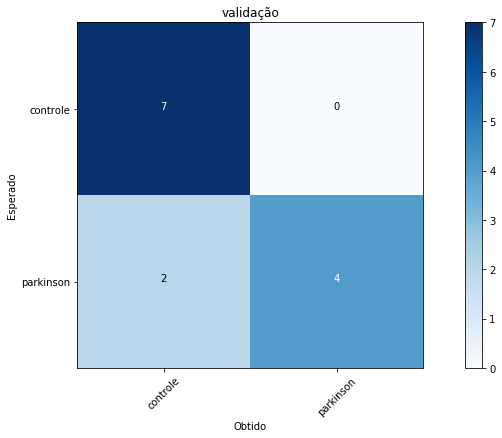

In [21]:
# Matriz de confusão
cnf_matrix = confusion_matrix(y_validade, y_predV)
np.set_printoptions(precision=2)
# Sem normalização
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=False, classes=nomes, title="validação")